# Implementation of Neural Style Transfer

## Author: Junyuan Zheng

## Date: 05/19/2020

# 1. Setup

## 1.1 Import modules

In [0]:
import tensorflow as tf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1.2 Import images

In [0]:
# content image path
content_path = './mayu_1.jpg'

In [0]:
style_path = './mosaic.jpg'

Function to __load__, __reshape__ image to limits its max dim to 512 pixels:

In [0]:
def load_img(path_to_img, max_dim=512):
    max_dim = max_dim
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], dtype=tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape*scale, dtype=tf.int32)
    
    img = tf.image.resize(img, size=new_shape)
    img = img[tf.newaxis, :] # (422, 512, 3) -> (1, 422, 512, 3)
    
    return img  

Function to __show__ image:

In [0]:
def show_img(img, title=None):
    if len(img.shape) > 3: # for caces such as (1, 422, 512, 3)
        img = tf.squeeze(img) # Removes dimensions of size 1 from the shape of a tensor
    
    plt.imshow(img)
    if title:
        plt.title(title)

In [0]:
# load content and style images
content_img = load_img(content_path)
style_img = load_img(style_path)

In [9]:
# check the shapes
print ('shape of the content img:', content_img.shape)
print ('shape of the style img:', style_img.shape)

shape of the content img: (1, 340, 511, 3)
shape of the style img: (1, 425, 511, 3)


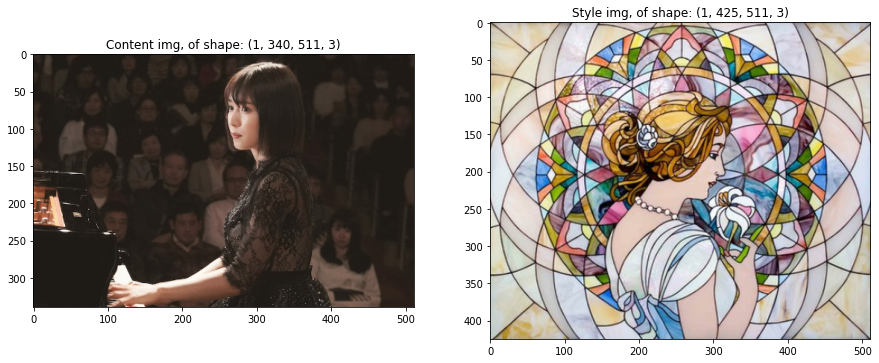

In [10]:
# show the content and style images
plt.figure(figsize=[15, 15])
plt.subplot(1,2,1)
show_img(content_img, title='Content img, of shape: '+str(content_img.shape))
plt.subplot(1,2,2)
show_img(style_img, title='Style img, of shape: '+str(style_img.shape))

- Content image: Japanese actress Mayu Matsuoka (松岡茉優) in the movie 『蜜蜂と遠雷』.
- Style image: "Mosaic" style image from Google Image (original source unknown).

## 1.3 Generate image to be optimized

In [0]:
# initialize the image to be the same the content image
image = tf.Variable(content_img)

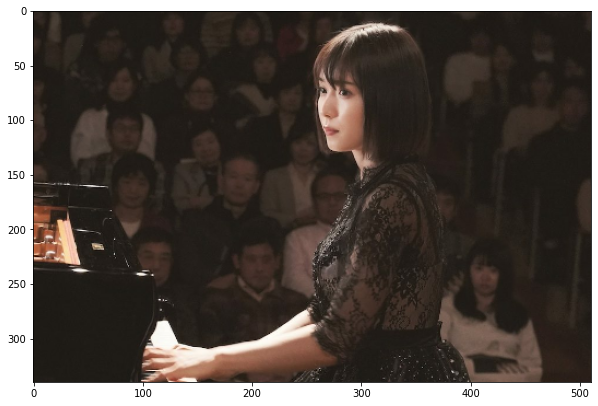

In [60]:
plt.figure(figsize=[10, 10])
show_img(image)

# 2. Load Pretrained Model - VGG19

__NOTE:__ VGG19 expects (224, 224, 3) input images for prediction. However, in this task, we are not going to use the FC layers in the top, so it is okay to import images with other shapes, as long as the content image and the generated image have the same shape.

In [13]:
# import VGG19 with top FC layers excluded
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
# lock the weights
vgg19.trainable = False

In [15]:
# check the layer names
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
#tf.keras.utils.plot_model(vgg19)

In [0]:
# define layers for the content and style information
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
style_layers_weights = {'block1_conv1': 0.25,
                        'block2_conv1': 0.25,
                        'block3_conv1': 0.20,
                        'block4_conv1': 0.15,
                        'block5_conv1': 0.15}

# 3. The Model

## 3.1 Get content target (A_c), and style target (G_s)

Function that takes in layer names of VGG19 and returns list of __intermediate layer outputs__:

In [0]:
# this is a 'Model'
def vgg19_layers_outputs(layer_names): # in list
    #vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    #vgg19.trainable = False
    
    inputs = [vgg19.input]
    outputs = [vgg19.get_layer(layer_name).output for layer_name in layer_names]
    model = tf.keras.Model(inputs=inputs, outputs=outputs) # Keras Functional API
    return model

Function to calculate the __Gram Matrix__ (scaled):

$$
G_{cd}^{\ [l]} = \sum_{i} \sum_{j} A_{ijc}^{\ [l]} A_{ijd}^{\ [l]} = \sum_{i} \sum_{j} A_{ijc}^{\ [l]} A_{ijd}^{\ [l]} = G^{[l]}_{(gram)n_C,n_C}
$$

$$
G_{cd}^{\ [l] \ \prime} = \frac{\sum_{i} \sum_{j} A_{ijc}^{\ [l]} A_{ijd}^{\ [l]}}{IJ} = \frac{G^{[l]}_{(gram)n_C,n_C}}{n_H^{\ [l]}n_W^{\ [l]}}
$$

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], dtype=tf.float32)
    # num_locations -> n_H*n_W
    return result / num_locations

Model that returns the content tensors (activations) and style tensors (gram matrix), given an input image:

In [0]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, **kwargs):
        super().__init__(**kwargs)
        self.vgg = vgg19_layers_outputs(style_layers + content_layers) # call the keras.Model()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}     

In [0]:
##################
# initiate model #
##################
extractor = StyleContentModel(style_layers, content_layers)

In [0]:
# get content target A_c
content_targets = extractor(content_img)['content']

In [230]:
for name, i in content_targets.items():
    print (name, i.shape)

block5_conv2 (1, 21, 31, 512)


In [0]:
# get style target G_s
style_targets = extractor(style_img)['style']

In [232]:
for name, i in style_targets.items():
    print (name, i.shape)

block1_conv1 (1, 64, 64)
block2_conv1 (1, 128, 128)
block3_conv1 (1, 256, 256)
block4_conv1 (1, 512, 512)
block5_conv1 (1, 512, 512)


## 3.2 Define optimizer (Adam)

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, epsilon=1e-07)

## 3.3 Define the loss function

$$
J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2
$$

$$
J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times {n_H}^2 \times {n_W}^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2
$$

$$
J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)
$$

$$
J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)
$$

$$
J(G)^\prime = \alpha J_{content}(C,G) + \beta J_{style}(S,G) + (\gamma J_{Total \ Variation})
$$

In [0]:
# alpha
content_weight = 0.5e4
# beta
style_weight = 1e-2
# gamma
total_variation_weight = 50

Function to calculate the __loss__:

In [0]:
def style_content_loss(outputs):
    content_outputs = outputs['content']
    style_outputs = outputs['style']
    
    content_loss = tf.add_n([tf.reduce_mean( (content_outputs[name]-content_targets[name])**2 )
                             for name in content_outputs.keys()])
    content_loss = content_loss * content_weight / 4
    #tf.reduce_mean -> /(n_H*n_W*n_C) -> /4
    
    
    style_loss = tf.constant(0.0)
    for name in style_outputs.keys():
        style_loss += tf.reduce_mean( (style_outputs[name]-style_targets[name])**2 ) * style_layers_weights[name]
    style_loss = style_loss * style_weight / 4
    #tf.reduce_mean -> /(n_C*n_C) -> /4

#or:
#   style_loss = tf.add_n( [style_layers_weights[name] * tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
#                            for name in style_outputs.keys()] )
#   style_loss = style_loss * style_weight / 4

    loss = content_loss + style_loss
    return loss  

Function to __clip__ the image between 0 and 1:

In [0]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## 3.4 Build the training function

Function to perform __one step of backprop__:

In [0]:
#@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss = loss + total_variation_weight*tf.image.total_variation(image) # add the total variation loss
    grad = tape.gradient(loss, image) # compute gradients using Autodiff
    
    optimizer.apply_gradients([(grad, image)]) # update image
    image.assign(clip_0_1(image)) # clipping

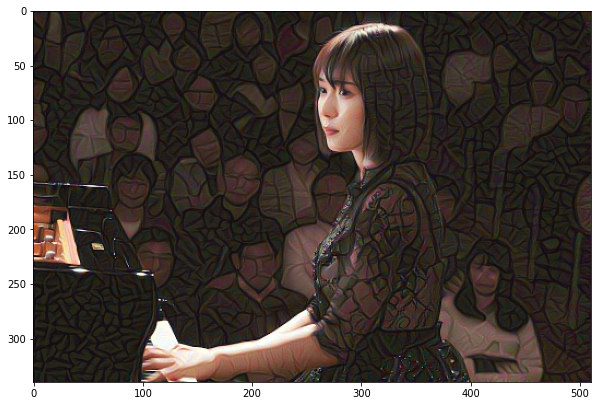

In [238]:
# test training for a few steps
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
plt.figure(figsize=[10,10])
show_img(image)

# 4. Model Training

In [0]:
# set epochs and number of steps (backprops) per epoch
epochs = 10
steps = 50

In [0]:
# list to record change of the image during epochs of training
IMGs = list()

In [241]:
import time
start = time.time()

for e in range(epochs):
    print ('epoch '+str(e+1)+' ongoing...')
    for s in range(steps):
        train_step(image)
    curr_image = tf.Variable(image)
    IMGs.append(curr_image)
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

epoch 1 ongoing...
epoch 2 ongoing...
epoch 3 ongoing...
epoch 4 ongoing...
epoch 5 ongoing...
epoch 6 ongoing...
epoch 7 ongoing...
epoch 8 ongoing...
epoch 9 ongoing...
epoch 10 ongoing...
Total time: 35.4


# 5. Results

## 5.1 Display results

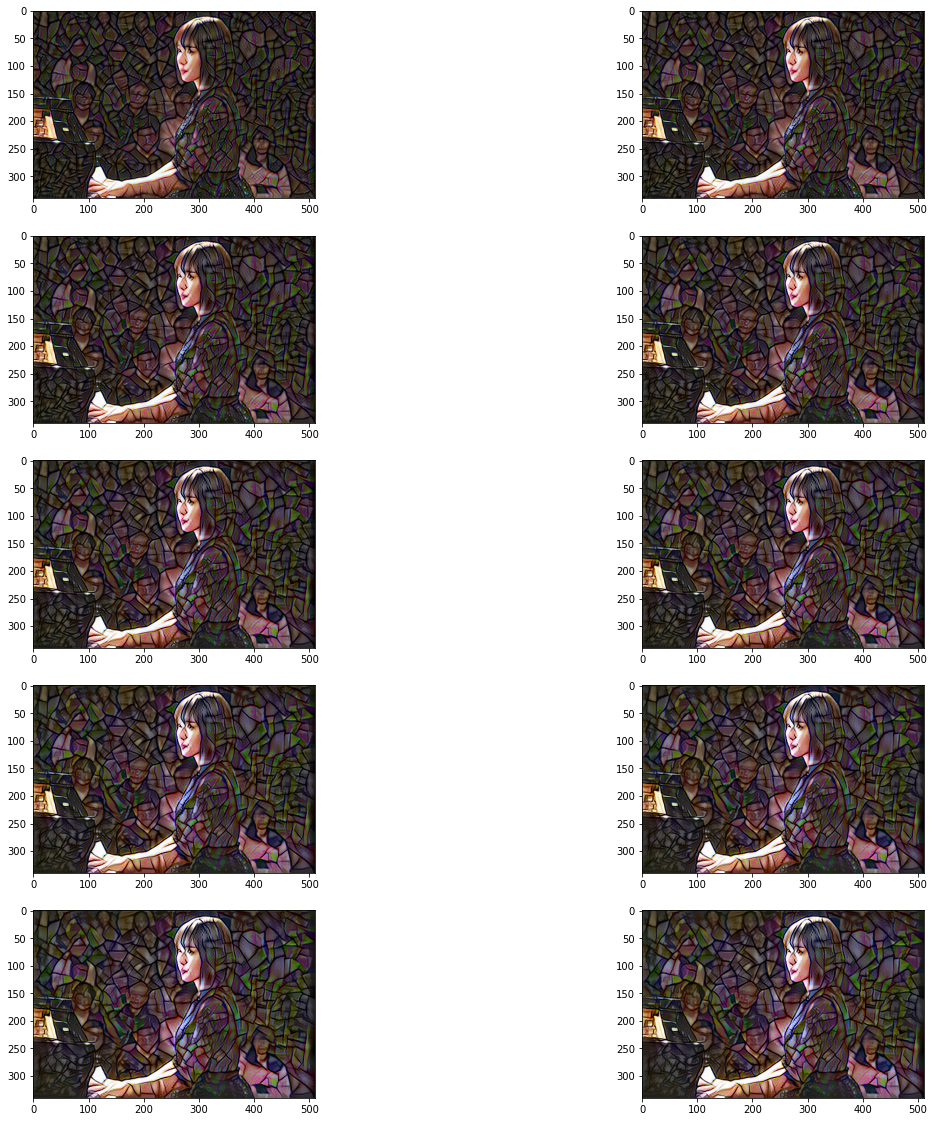

In [242]:
# images during the training
plt.figure(figsize=[20,20])
for i in range(len(IMGs)):
    plt.subplot(5,2,i+1)
    show_img(IMGs[i])

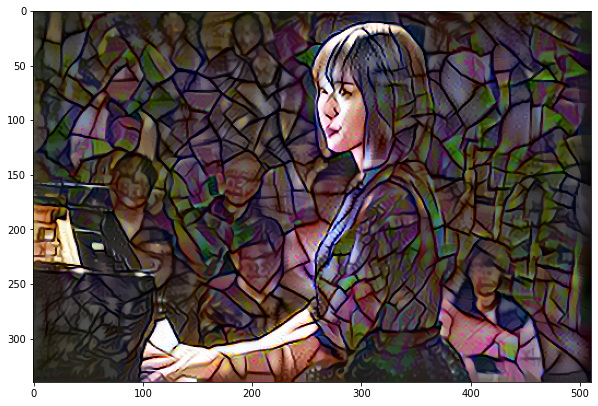

In [249]:
# result image
plt.figure(figsize=[10,10])
show_img(IMGs[-1])

# References:
- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style.
- TensorFlow Tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer.
- Coursera specialization: Deep Learning.